In [1]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")



In [2]:
df = pd.read_csv('saas.csv')

In [3]:
df['Month_Invoiced'] = pd.to_datetime(df.Month_Invoiced)
df.set_index('Month_Invoiced', inplace=True)


In [4]:
df.head()

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0


In [5]:
print(df.index.min())
print(df.index.max())

2014-01-31 00:00:00
2017-12-31 00:00:00


### Split data (train/test) and resample by any period except daily, and aggregate using the sum.


In [6]:
aggregation = 'sum'

train = df[:'2016'].Amount.resample('M').agg(aggregation)
test = df['2017':].Amount.resample('M').agg(aggregation)


In [7]:
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))


Observations: 48
Training Observations: 36
Testing Observations: 12


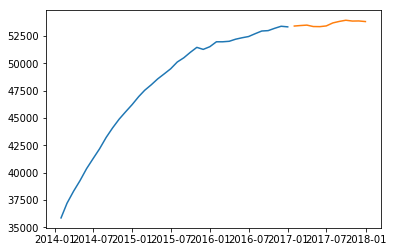

In [8]:
plt.plot(train)
plt.plot(test)
plt.show()


In [9]:
def plot_data_and_predictions(predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

### Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:


#### simple average


In [10]:
yhat = pd.DataFrame(dict(actual=test))
yhat['avg_forecast'] = train.mean()
yhat.head()


,actual,avg_forecast
Month_Invoiced,,
2017-01-31,53395.0,47916.666667
2017-02-28,53440.0,47916.666667
2017-03-31,53480.0,47916.666667
2017-04-30,53350.0,47916.666667
2017-05-31,53340.0,47916.666667


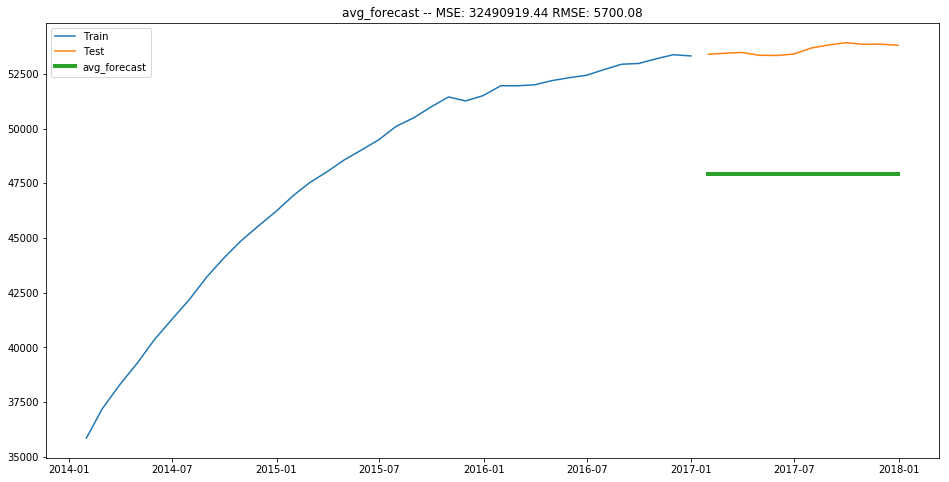

In [11]:
plot_and_eval(yhat.avg_forecast)


#### moving average


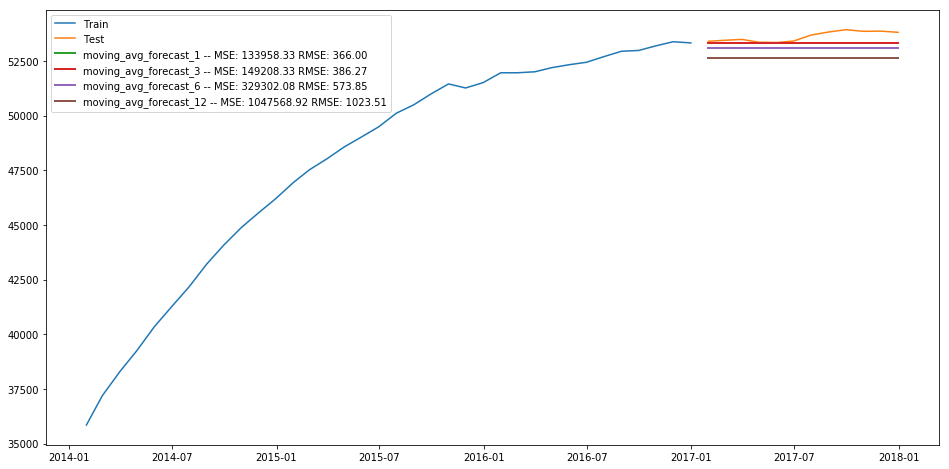

In [12]:
period_vals = [1,3,6,12]

for periods in period_vals:
    yhat[f'moving_avg_forecast_{periods}'] = train.rolling(periods).mean().iloc[-1]

forecasts = [yhat[f'moving_avg_forecast_{p}'] for p in period_vals]

plot_and_eval(forecasts, linewidth=2)



#### Holt's linear trend model


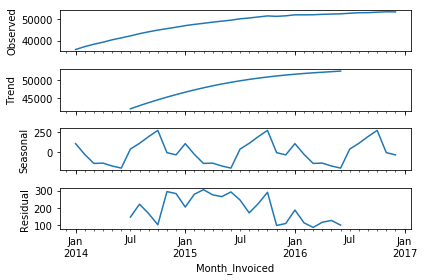

In [13]:
import statsmodels.api as sm

sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()


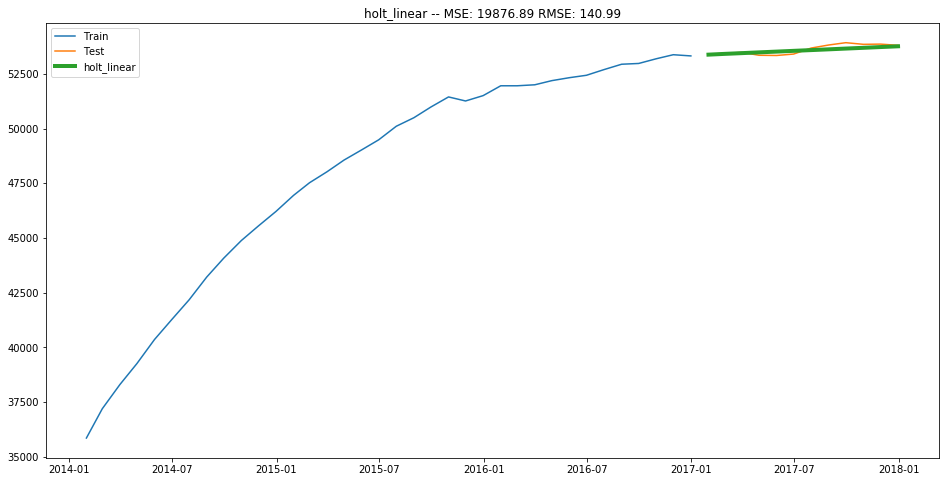

In [14]:
from statsmodels.tsa.api import Holt

holt = Holt(train).fit(smoothing_level=.9, smoothing_slope=.7)

yhat['holt_linear'] = holt.forecast(test.shape[0])

plot_and_eval(yhat.holt_linear)


#### Based on previous year/month/etc (your choice)


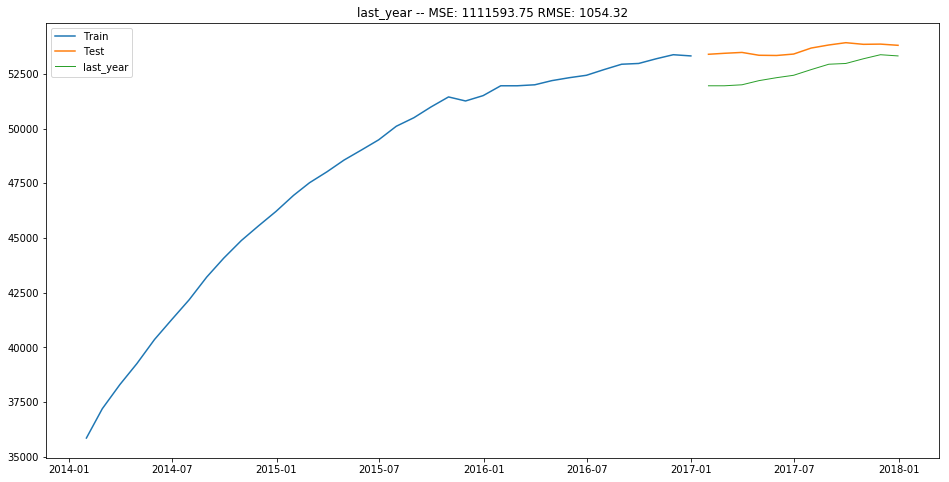

In [15]:
using_last_year = train['2016']\
    .reset_index()\
    .drop(columns='Month_Invoiced')\
    .set_index(train['2016'].index + 12)

yhat['last_year'] = using_last_year

plot_and_eval(yhat.last_year, linewidth=1)


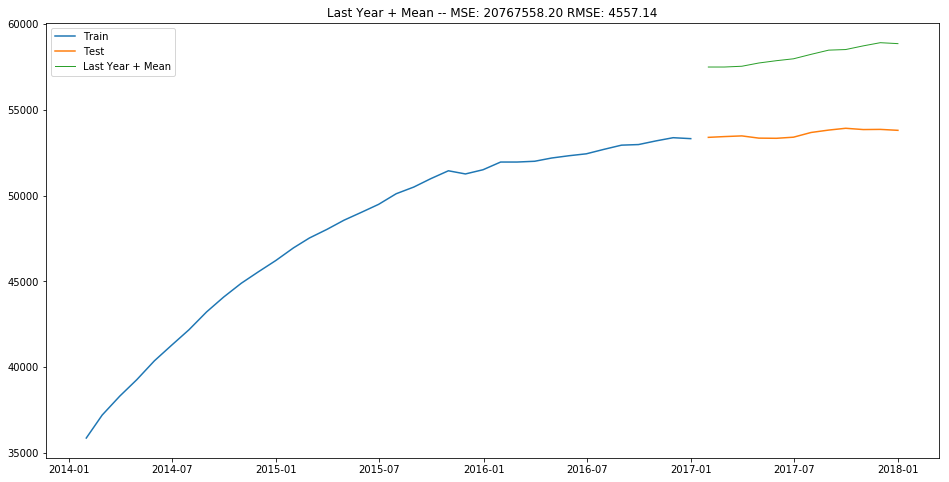

In [16]:
predictions = train['2016'] + train.diff(12).mean()
predictions.index = pd.date_range('20170101', periods=12, freq='M')
predictions = predictions
predictions.name = 'Last Year + Mean'

plot_and_eval(predictions, linewidth=1)


## Using store data


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import acquire
import prepare

In [18]:
df = acquire.get_full_df_csv()

In [19]:
dt_format = '%a, %d %b %Y %H:%M:%S %Z'
df['sale_date'] = pd.to_datetime(df.sale_date, format= dt_format)



In [20]:
d_df = df[df['store_id']==2]
d_df = d_df[d_df['item_brand']=='Zhenas Gypsy Tea']


In [21]:
d_df['y'] = d_df.sale_amount * d_df.item_price
d_df['ds'] = pd.to_datetime(d_df.sale_date)
d_df = d_df.groupby(['ds'])['y'].sum().reset_index()


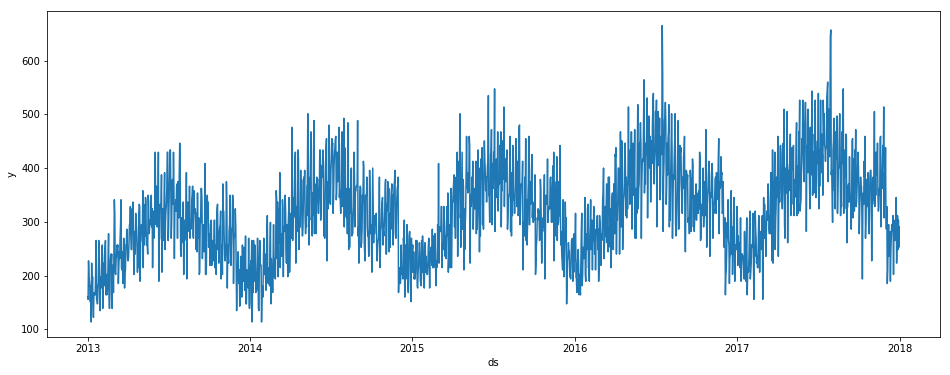

In [22]:
plt.figure(figsize=(16,6))
sns.lineplot(d_df.ds, d_df.y)


In [23]:
d_df['cap'] = 600
d_df['floor'] = 100

m = Prophet(daily_seasonality=True, growth='logistic', changepoint_range=0.9)
m.fit(d_df)

In [24]:
future = m.make_future_dataframe(periods=180)
future['cap'] = 600
future['floor'] = 100
print(future.head())
print(future.tail())
print(d_df.tail())

          ds  cap  floor
0 2013-01-01  600    100
1 2013-01-02  600    100
2 2013-01-03  600    100
3 2013-01-04  600    100
4 2013-01-05  600    100
             ds  cap  floor
2001 2018-06-25  600    100
2002 2018-06-26  600    100
2003 2018-06-27  600    100
2004 2018-06-28  600    100
2005 2018-06-29  600    100
             ds       y  cap  floor
1821 2017-12-27  311.54  600    100
1822 2017-12-28  248.39  600    100
1823 2017-12-29  303.12  600    100
1824 2017-12-30  252.60  600    100
1825 2017-12-31  290.49  600    100


In [25]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2001,2018-06-25,389.436815,341.098902,447.628418
2002,2018-06-26,430.499643,374.091717,482.781841
2003,2018-06-27,431.242011,378.846550,478.982729
2004,2018-06-28,451.755149,403.712073,506.997505
2005,2018-06-29,472.388963,420.179179,521.678733


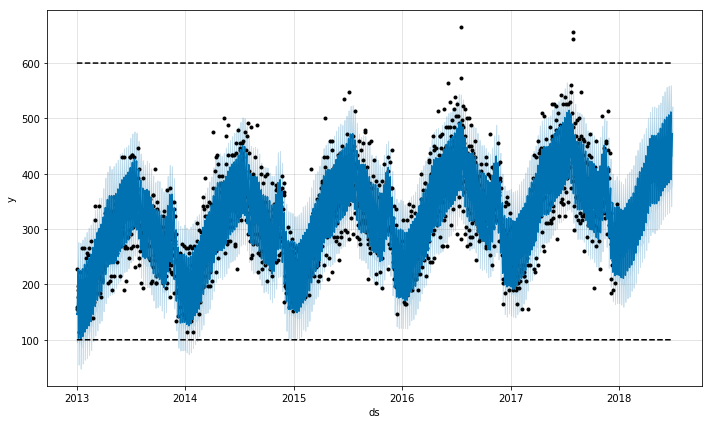

In [26]:
fig1 = m.plot(forecast)


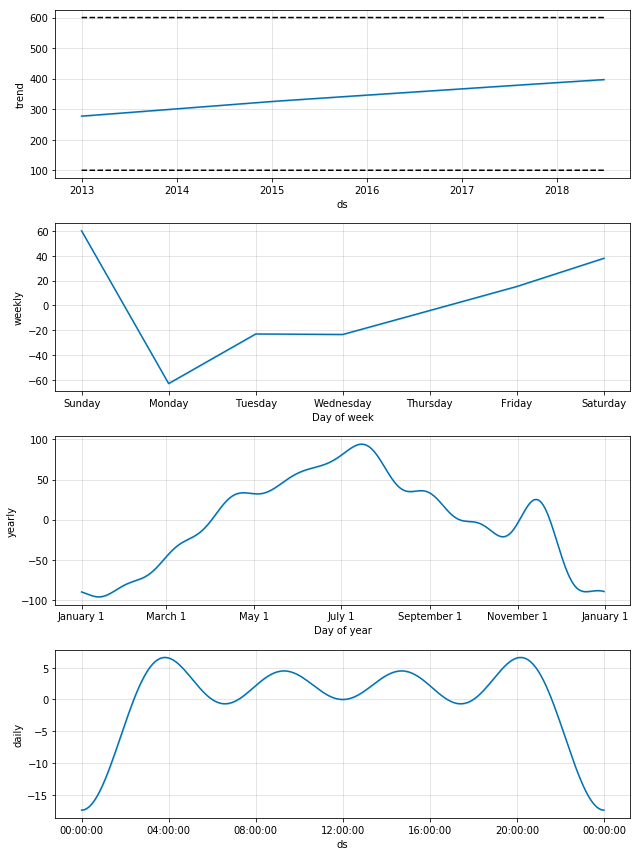

In [27]:
fig2 = m.plot_components(forecast)


In [28]:
from fbprophet.diagnostics import cross_validation, performance_metrics
# cross_validation(m, initial = 730, period = 180, horizon = 365, units = 'days')
df_cv = cross_validation(m, horizon='90 days')


df_p = performance_metrics(df_cv)
df_p.head(5)


INFO:fbprophet:Making 33 forecasts with cutoffs between 2013-10-23 00:00:00 and 2017-10-02 00:00:00


,horizon,mse,rmse,mae,mape,coverage
278,9 days,2080.442472,45.611868,35.630687,0.120205,0.680135
1899,10 days,2092.722090,45.746280,35.823586,0.120588,0.676768
369,10 days,2095.873432,45.780710,35.884252,0.120757,0.676768
639,10 days,2095.338236,45.774865,35.877847,0.120407,0.676768
729,10 days,2092.545747,45.744352,35.782497,0.120151,0.676768


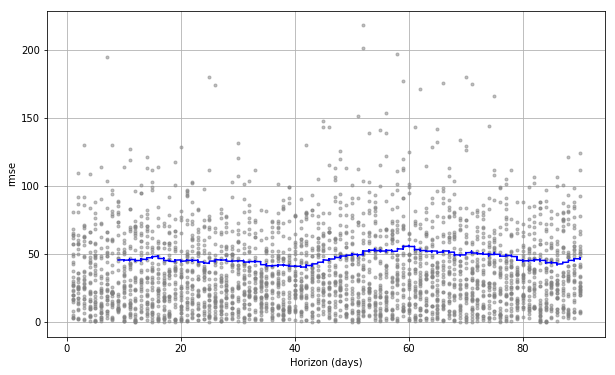

In [29]:
from fbprophet.plot import plot_cross_validation_metric, plot_forecast_component

# plot_forecast_component(m, forecast, 'yhat')

fig3 = plot_cross_validation_metric(df_cv, metric='rmse')


In [30]:
forecast

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,277.216163,600,100,95.589980,201.282747,277.216163,277.216163,-130.696689,-130.696689,...,-23.026368,-23.026368,-23.026368,-90.237767,-90.237767,-90.237767,0.0,0.0,0.0,146.519474
1,2013-01-02,277.280219,600,100,95.529006,192.361306,277.280219,277.280219,-131.670757,-131.670757,...,-23.409164,-23.409164,-23.409164,-90.829039,-90.829039,-90.829039,0.0,0.0,0.0,145.609462
2,2013-01-03,277.344285,600,100,110.728770,216.842634,277.344285,277.344285,-112.990150,-112.990150,...,-4.081579,-4.081579,-4.081579,-91.476017,-91.476017,-91.476017,0.0,0.0,0.0,164.354135
3,2013-01-04,277.408361,600,100,133.995331,237.684934,277.408361,277.408361,-94.280745,-94.280745,...,15.310570,15.310570,15.310570,-92.158760,-92.158760,-92.158760,0.0,0.0,0.0,183.127617
4,2013-01-05,277.472449,600,100,153.435874,255.820747,277.472449,277.472449,-72.230457,-72.230457,...,38.057710,38.057710,38.057710,-92.855614,-92.855614,-92.855614,0.0,0.0,0.0,205.241991
5,2013-01-06,277.536546,600,100,178.074142,276.399232,277.536546,277.536546,-50.800701,-50.800701,...,60.175837,60.175837,60.175837,-93.543984,-93.543984,-93.543984,0.0,0.0,0.0,226.735845
6,2013-01-07,277.600654,600,100,55.099348,156.095789,277.600654,277.600654,-174.660680,-174.660680,...,-63.027007,-63.027007,-63.027007,-94.201119,-94.201119,-94.201119,0.0,0.0,0.0,102.939974
7,2013-01-08,277.664772,600,100,91.678050,192.504136,277.664772,277.664772,-135.263773,-135.263773,...,-23.026368,-23.026368,-23.026368,-94.804852,-94.804852,-94.804852,0.0,0.0,0.0,142.400999
8,2013-01-09,277.728901,600,100,92.180562,194.747851,277.728901,277.728901,-136.176032,-136.176032,...,-23.409164,-23.409164,-23.409164,-95.334314,-95.334314,-95.334314,0.0,0.0,0.0,141.552869
9,2013-01-10,277.793040,600,100,105.565887,209.503835,277.793040,277.793040,-117.284708,-117.284708,...,-4.081579,-4.081579,-4.081579,-95.770576,-95.770576,-95.770576,0.0,0.0,0.0,160.508332
